In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import GradientBoostingRegressor
import datetime
import category_encoders as ce
df = pd.read_csv('/Users/harleyhoffmann/dat-02-22/ClassMaterial/Unit3/data/bikeshare.csv')

In [4]:
#  - datetime: a timestamp collected hourly.
#  - season: a categorical column that lists the current season for that observation
# - holiday: a column (0 or 1), that detects whether or not it was a holiday
#  - workingday: a column (0 or 1), that encodes whether or not it was a workday or not
#  - weather: a categorical column that lists a light weather description for the observation
#  - temp: the temperature outside
#  - atemp: the temperature it feels like outside
#  - humidity: the humidity outside
#  - windspeed: the windspeed, in mph
#  - count: the number of bikes checked out during that hour

#reset datetime column to datetime
df['datetime']= pd.to_datetime(df['datetime'])

In [5]:
px.line(df, x='datetime', y='count', title='Bikeshare Rentals 2011-2012', labels={'datetime': 'Time', 'count': 'Number of Bikes/hour'})

No major surprises - big rentals increase in the summer months due to warm weather.
However, within those timelines there is a lot of noise, further discover is required.

In [6]:
px.line(df, x='datetime', y=['temp','atemp'], title='Temperature 2011-2012', labels={'datetime': 'Time'})

At first glance, it appears that the change in season, commonly associated with warmer temperatures in the summertime, has the largest impact on ride count. However we'll use our model fitting and scoring to determine which features actually have the most importance.

In [7]:
#it looks like the data is already sorted, but we're going to sort values just to be sure
df.sort_values(by=['datetime'], ascending=True, inplace=True)

In [8]:
#we're separating out the date aspects into their own columns to see how they effect the model
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['year'] = pd.DatetimeIndex(df['datetime']).year
df['day_of_month'] = pd.DatetimeIndex(df['datetime']).day
df['hour_of_day'] = pd.DatetimeIndex(df['datetime']).hour
df['day_of_week'] = pd.DatetimeIndex(df['datetime']).dayofweek

Let's take a look at the data now:

In [9]:
px.scatter(df, x='hour_of_day', y='count', title='Bikeshares through the day 2011-2012', labels={'hour_of_day': 'Hour of the day', 'count': 'Bike rentals'}, trendline='ols', color='count')

It looks like there is also great fluctuation in the bike rental counts based on the hour of the day - with more rentals throughout of the afternoon and evening.

In [11]:
df = df.set_index(['datetime'])

In [12]:
# define a function that we can reuse to make a training, validation, and test set
def create_val_splits(df, val_units=15, return_val=False):
    """Function that will take in a dataset and split it up into training, validation, and test sets"""
    # split into training, validation, and test sets
    train = df.apply(lambda x: x.iloc[:-val_units]).reset_index(drop=True)
    test  = df.apply(lambda x: x.iloc[-val_units:]).reset_index(drop=True)
    
    if return_val:
        val   = train.apply(lambda x: x.iloc[-val_units:]).reset_index(drop=True)
        train = train.apply(lambda x: x.iloc[:-val_units]).reset_index(drop=True)
        return train, val, test
    else:
        return train, test

In [13]:
train, val, test = create_val_splits(df, val_units=1728, return_val=True)
#we're taking 2,160 rows of the most recent 4 months of data near the end of year 2012 for test and then the same again for the validation set
#there are only the first 18 days in each month
#432 rows is 18 days in hours
#24 hours in a day x 18 x 4 = 1,728

In [14]:
#creating our training and validation sets
X_train = train.drop('count', axis=1)
y_train = train['count']
X_val = val.drop('count', axis=1)
y_val = val['count']

In [15]:
#load in the GBM and the encoders so we can make a pipeline for each to test
from sklearn.pipeline import make_pipeline
gbm = GradientBoostingRegressor()
te = ce.TargetEncoder()
ore = ce.OrdinalEncoder()
ohe = ce.OneHotEncoder()

In [16]:
#make a pipeline to test each encoder to do our initial fitting
pipe1 = make_pipeline(te, gbm)
pipe2 = make_pipeline(ore, gbm)
pipe3 = make_pipeline(ohe, gbm)

In [17]:
#test each Encoder on the validation set using each pipeline
#Target Encoder
pipe1.fit(X_train, y_train)
pipe1.score(X_val,y_val)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.791763811297405

In [18]:
#Ordinal Encoder
pipe2.fit(X_train, y_train)
pipe2.score(X_val,y_val)

0.793524463752546

In [19]:
#OneHotEncoder
pipe3.fit(X_train, y_train)
pipe3.score(X_val,y_val)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.7899197546506231

After our initial fitting, we've got rather similar scores for each Encoder.
We're going to use the Target Encoder because we have categorical values in the weather and seasons columns and because we can take a look at the feature importances easier with this Encoder.

In [20]:
#Target Encoder
pipe1.fit(X_train, y_train)
pipe1.score(X_val,y_val)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.7920148510437631

Take a look at the feature importances for each column to make assumptions about what affects the training data the most

In [21]:
#Load features and importance into a dataframe
feats = pd.DataFrame({'Features':X_train.columns, 'Importance':gbm.feature_importances_}).sort_values(by='Importance', ascending=False)
feats

Features  Importance
11   hour_of_day    0.662840
5          atemp    0.126950
2     workingday    0.059727
9           year    0.059410
8          month    0.026984
4           temp    0.017992
3        weather    0.014901
6       humidity    0.012910
12   day_of_week    0.011430
0         season    0.004314
7      windspeed    0.001616
10  day_of_month    0.000806
1        holiday    0.000120

In [22]:
px.bar(feats, x='Features', y='Importance', title='Features by Importance', color='Importance')

Let's make some moving averages to try and improve our score.

In [23]:
#It appears hour_of_day has a big effect, so let's make some rolling 24, 48, 72 hour summary statistics
df['24_hour_avg']  = df['count'].rolling('24H').mean().shift().values
df['48_hour_avg'] = df['count'].rolling('48H').mean().shift().values
df['72_hour_avg'] = df['count'].rolling('72H').mean().shift().values


In [24]:
#backfill, and split the data
df['24_hour_avg'] = df['24_hour_avg'].bfill()
df['48_hour_avg'] = df['48_hour_avg'].bfill()
df['72_hour_avg'] = df['72_hour_avg'].bfill()

train, val, test = create_val_splits(df, val_units=1728, return_val=True)

In [25]:
#recreate our training x,y and validation x,y
X_train = train.drop('count', axis=1)
y_train = train['count']
X_val = val.drop('count', axis=1)
y_val = val['count']

In [26]:
#rerun our Target Encoder pipeline
pipe1.fit(X_train, y_train)
pipe1.score(X_val,y_val)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.7841294020729567

Although only a modest improvement, these are still real improvements, so let's keep them.

With this tweak we've improved our out-of-sample score by a little bit more!

Now we'll add some other counts from previous hours/dates:

In [27]:
#create last_hour, yesterday, last week
df['last_hour'] = df['count'].shift().values
df['yesterday'] = df['count'].shift(24).values
df['last_week'] = df['count'].shift(168).values
#backfill each
df['last_hour'] = df['last_hour'].bfill()
df['yesterday'] = df['yesterday'].bfill()
df['last_week'] = df['last_week'].bfill()

Now let's recreate our training and validation and score

In [28]:
train, val, test = create_val_splits(df, val_units=1728, return_val=True)

#recreate our training x,y and validation x,y
X_train = train.drop('count', axis=1)
y_train = train['count']
X_val = val.drop('count', axis=1)
y_val = val['count']

Rescore on our validation set:

In [29]:
pipe1.fit(X_train, y_train)
pipe1.score(X_val,y_val)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.9032819893380846

A lot better.
Now, we'll try adjusting our GBM parameters to see if we can improve our score.

In [30]:
# we'll try a GBM that only uses 70% of columns at each split, with our new pipe without a number after
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor(max_features=0.7))

# and see our results
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.8911623936349058

Oof, not better. Let's try checking a lot of model variations of our original pipe

In [31]:
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())

In [32]:
#let's check a lot of versions of the model at once
n_estimators  = [100, 200, 500]
learning_rate = [.05, .1, 1.5]
max_depth     = [3, 4, 5, 6]
cv_scores     = []

# and cycle through our model parameters
for estimators in n_estimators:
    for rate in learning_rate:
        for depth in max_depth:
            print(f"Fitting model with parameters:  n_estimators - {estimators}, learning_rate - {rate}, max_depth - {depth}")
            mod   = GradientBoostingRegressor(n_estimators=estimators, learning_rate=rate, max_depth=depth, max_features=0.6)
            pipe  = make_pipeline(ce.TargetEncoder(), mod)
            pipe.fit(X_train, y_train)
            score = pipe.score(X_val, y_val)
            print(f"Out-of-sample score: {score}")
            cv_scores.append((score, estimators, rate, depth))

Fitting model with parameters:  n_estimators - 100, learning_rate - 0.05, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.8559491551570828
Fitting model with parameters:  n_estimators - 100, learning_rate - 0.05, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.8920627730175111
Fitting model with parameters:  n_estimators - 100, learning_rate - 0.05, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9032697273526654
Fitting model with parameters:  n_estimators - 100, learning_rate - 0.05, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9163138329834126
Fitting model with parameters:  n_estimators - 100, learning_rate - 0.1, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.8966577711887023
Fitting model with parameters:  n_estimators - 100, learning_rate - 0.1, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9024556156634163
Fitting model with parameters:  n_estimators - 100, learning_rate - 0.1, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9195593099898984
Fitting model with parameters:  n_estimators - 100, learning_rate - 0.1, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9215421374602379
Fitting model with parameters:  n_estimators - 100, learning_rate - 1.5, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.444964580206357
Fitting model with parameters:  n_estimators - 100, learning_rate - 1.5, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.15313276697787748
Fitting model with parameters:  n_estimators - 100, learning_rate - 1.5, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: -1.2581384933787945
Fitting model with parameters:  n_estimators - 100, learning_rate - 1.5, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.31235004000663447
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.05, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.8957681884752102
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.05, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.910255521557487
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.05, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9229659329549107
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.05, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9272532556311534
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.1, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.8947528732280179
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.1, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9175344291523408
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.1, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9106104714224217
Fitting model with parameters:  n_estimators - 200, learning_rate - 0.1, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9164135278898551
Fitting model with parameters:  n_estimators - 200, learning_rate - 1.5, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.4788459013068751
Fitting model with parameters:  n_estimators - 200, learning_rate - 1.5, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.22605703963775414
Fitting model with parameters:  n_estimators - 200, learning_rate - 1.5, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.314851144261028
Fitting model with parameters:  n_estimators - 200, learning_rate - 1.5, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.06790577262925868
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.05, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.898459434768413
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.05, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9155029693797312
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.05, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9173501634909236
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.05, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9297479841529164
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.1, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.8887979666572462
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.1, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9077334963140828
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.1, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9253630374100271
Fitting model with parameters:  n_estimators - 500, learning_rate - 0.1, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.9213785498202162
Fitting model with parameters:  n_estimators - 500, learning_rate - 1.5, max_depth - 3


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: -0.8443802320560698
Fitting model with parameters:  n_estimators - 500, learning_rate - 1.5, max_depth - 4


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.3498221458244992
Fitting model with parameters:  n_estimators - 500, learning_rate - 1.5, max_depth - 5


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: -0.34916656785260036
Fitting model with parameters:  n_estimators - 500, learning_rate - 1.5, max_depth - 6


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Out-of-sample score: 0.133833889049081


In [33]:
#let's grab the best version of our model
max(cv_scores)

(0.9297479841529164, 500, 0.05, 6)

In [34]:
#best version of our model
mod = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)

In [35]:
#Now we want all the training data for the final sample
train, test = create_val_splits(df, val_units=1728, return_val=False)

In [36]:
#Create our full training and test sets without a validation set
X_train, y_train = train.drop('count', axis=1), train['count']
X_test, y_test = test.drop('count', axis=1), test['count']

In [37]:
#Final pipeline with final model
pipe = make_pipeline(ce.TargetEncoder(), mod)

In [38]:
#final fitting on the whole training set
pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Pipeline(steps=[('targetencoder', TargetEncoder(cols=['season', 'weather'])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                           n_estimators=500))])

In [39]:
#final out of sample model performance on test set which the model has never seen
pipe.score(X_test, y_test)

0.9382405301641293

Summary:
    
This is great! Our test score was better than our validation score, which is fantastic. Our validation set adjustments over the course of this notebook really improved our score and it shows on the out-of-sample test data. It appears the hourly (as expected) data really has a drastic effect on the predictive analysis the model can perform. By making summary statistics and other variations around the hour of the day (i.e. the counts for one hour ago, yesterday, last week) had a solid impact on the model score overall. Once we were able to determine that that the hour_of_day feature had the most importance it made most sense to expand on that feature to improve the model score.

In [41]:
#Now let's make some PDP Summary Plots
from pdpbox import pdp, info_plots

In [40]:
#Pipe[0] is our TargetEncoder
transformed_X = pipe[0].transform(X_train)

Now let's make our plot for hour_of_day

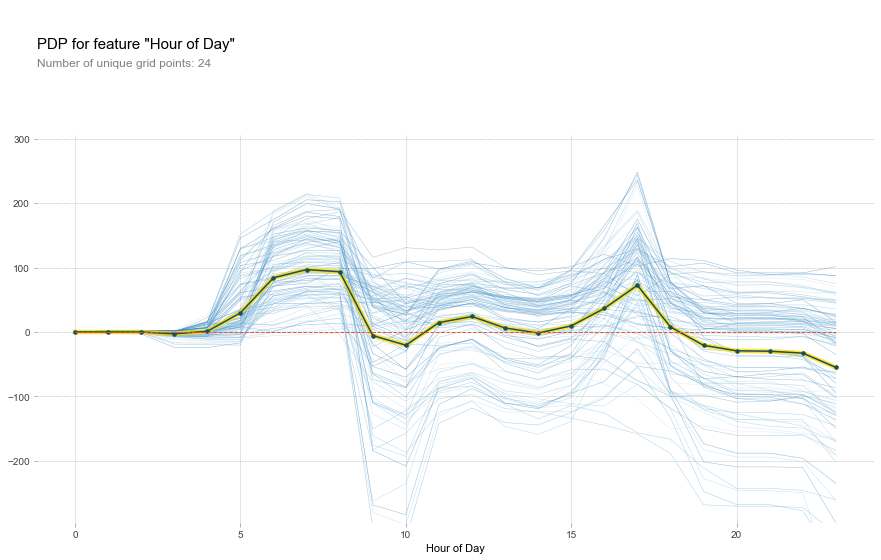

In [43]:
# This shows the additive impact of EACH unique hour_of_day
pdp_hour_of_day = pdp.pdp_isolate(
    model=pipe[1], dataset=transformed_X, model_features=transformed_X.columns.tolist(), 
    feature='hour_of_day', cust_grid_points = transformed_X['hour_of_day'].unique().tolist()
)

fig, axes = pdp.pdp_plot(pdp_hour_of_day, 'Hour of Day', plot_lines=True, frac_to_plot=100)

The positive impact in increased bike rentals here lies around the morning and evening commute hours with larger dips in bike rentals due to during lunch hours and later into the night

In [64]:
#make a new pipeline to OneHotEncode the weather column with our model - mod
pipe5 = make_pipeline(ce.OneHotEncoder(cols=['weather','season'], use_cat_names=True), ce.TargetEncoder(), mod)
# fit our model again
pipe5.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['weather', 'season'], use_cat_names=True)),
                ('targetencoder', TargetEncoder(cols=[])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                           n_estimators=500))])

In [65]:
# first, let's grab the columns with weather in them
weather_cols = [col for col in pipe5[0].get_feature_names() if 'weather' in col]
weather_cols

['weather_Clear Skies',
 'weather_Partly Cloudy',
 'weather_Light Storms/Rain',
 'weather_Heavy Storms/Rain']

In [66]:
transformed_ohe_X = pipe5[0].transform(X_train)

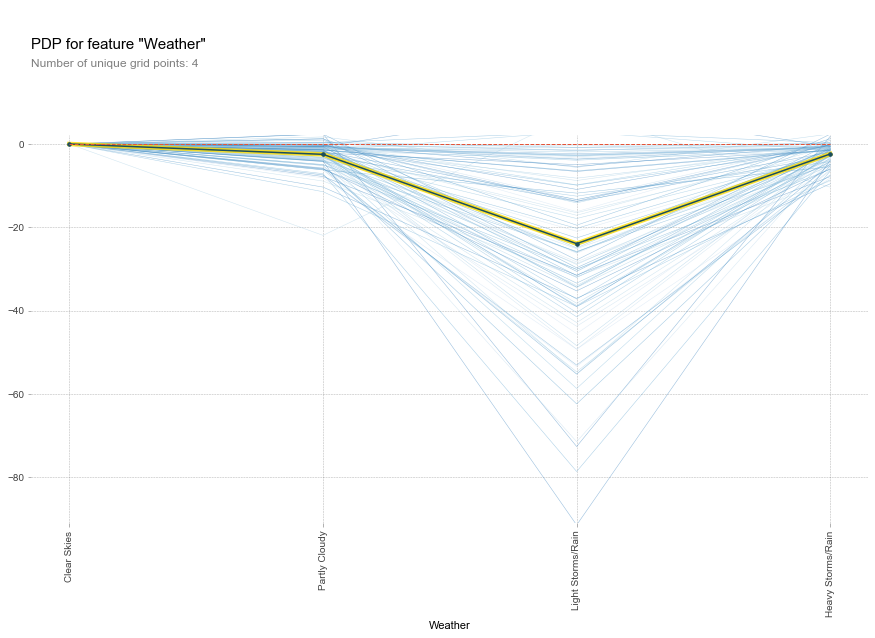

In [67]:
# what was the impact of weather on bike rides throughout the day
pdp_weather = pdp.pdp_isolate(
                    # dataset -- create the final transformation of our data
    model=pipe5[2], dataset=transformed_ohe_X, model_features=pipe5[0].get_feature_names(), 
    # this is the list of all the columns for the genre feature
    feature=weather_cols
)

fig, axes = pdp.pdp_plot(pdp_weather, 'Weather', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [weather.split('_')[1] for weather in weather_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

As a second look here, in the case of weather, we can see that Light Storms/Rain have the largest impact on decreased bike rentals in the dataset. 

These are just a few of the many PDP charts you could make. All in all there are many factors that impact the data here, with hour_of_day being the most impactful. This data, amongst additional columns as well, could be very informative information you could share with a bikeshare company to help them predict hourly rental volume based on a number of factors including upcoming seasons, temperature, days of the week and obviously the hour of the day.

In [74]:
#Now let's try and visualize our predictions for X_val and X_test
#refit our pipeline and predict X_test
pipe.fit(X_train, y_train)
X_test_preds = pipe.predict(X_test)
X_test_preds

array([130.72561241,  35.56729264,  14.42574079, ..., 156.42679868,
       117.67808952,  59.11273978])

In [75]:
#refit our pipeline and predict X_val
pipe.fit(X_train, y_train)
X_val_preds = pipe.predict(X_val)
X_val_preds

array([ 59.55107054,  31.44723468,  14.95939059, ..., 390.45925808,
       270.90997451, 189.54069018])

In [77]:
#let's make a DF of each predictions
X_test_predictions = pd.DataFrame({'hour_of_day':X_test['hour_of_day'], 'predictions':X_test_preds})
X_test_predictions

hour_of_day  predictions
0              23   130.725612
1               0    35.567293
2               1    14.425741
3               2     1.980163
4               3     4.079427
...           ...          ...
1723           19   385.686842
1724           20   221.553776
1725           21   156.426799
1726           22   117.678090
1727           23    59.112740

[1728 rows x 2 columns]

In [78]:
X_val_predictions = pd.DataFrame({'hour_of_day':X_val['hour_of_day'], 'predictions':X_val_preds})
X_val_predictions

hour_of_day  predictions
0              23    59.551071
1               0    31.447235
2               1    14.959391
3               2     6.400776
4               3     4.980654
...           ...          ...
1723           18   826.056087
1724           19   559.970340
1725           20   390.459258
1726           21   270.909975
1727           22   189.540690

[1728 rows x 2 columns]

Let's visualize each in a scatterplot like up top. The key thing to note is that the predictions are in different seasons, so this might have a little impact on the chart differences

In [80]:
#X_test predictions graph
px.scatter(X_test_predictions, x='hour_of_day', y='predictions', title='Bikeshares through the day - X Test Predictions', labels={'hour_of_day': 'Hour of the day', 'predictions': 'Predicted Bike Rentals'}, trendline='ols', color='predictions')

In [81]:
#X_val predictions graph
px.scatter(X_val_predictions, x='hour_of_day', y='predictions', title='Bikeshares through the day - X Validation Predictions', labels={'hour_of_day': 'Hour of the day', 'predictions': 'Predicted Bike Rentals'}, trendline='ols', color='predictions')

In final summary it appears that both predictions follow the general path of the graph at the beginning of this notebook, with bikeshares increasing throughout the day. Our validation predictions were a little higher than our test predictions. If we scroll all the way up, the original plot has the trendline ending the day below the 400 count mark, which validates why our Test score was higher than our validations score as it was most near to the original dataset. 